In [5]:
%matplotlib inline
from __future__ import print_function, division

import csv
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import normalize

In [25]:
def load_mallet_matrix(dirname, filename="doc_matrix.tsv", mallet_dir="mallet"):
    full_path = os.path.join(mallet_dir, dirname, filename)
    with open(full_path, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        app_ids = list()
        vectors = list()
        for line in reader:
            app_ids.append(np.int(line[1].split("/")[-1]))
            vector = np.array(map(np.float, line[2:]))
            vector /= np.linalg.norm(vector)
            vectors.append(vector)
    app_ids, vectors = np.array(app_ids), np.array(vectors)
    app_order = np.argsort(app_ids)
    app_ids = app_ids[app_order]
    vectors = vectors[app_order]
    return app_ids, vectors

def load_doc_tag_matrix(filename="doc_tag_matrix.npy", data_dir="data"):
    with open(os.path.join(data_dir, filename), "rb") as f:
        arr = np.load(f)
    return arr[:, 0], arr[:, 1:]

In [59]:
app_ids, descriptions_matrix = load_mallet_matrix("40_features_descriptions")
descriptions_matrix = normalize(descriptions_matrix)

# Some games are missing from this matrix, so we have to remove them
app_id_to_index = {app_id: i for i, app_id in enumerate(app_ids)}

app_ids_reviews, reviews_matrix = load_mallet_matrix("40_features")
to_delete = np.array([i 
                      for i, app_id in enumerate(app_ids_reviews)
                      if app_id not in app_id_to_index])


app_ids_reviews = np.delete(app_ids_reviews, to_delete)
reviews_matrix = np.delete(reviews_matrix, to_delete, axis=0)
reviews_matrix = normalize(reviews_matrix[np.argsort(app_ids_reviews)])

app_ids_jac, jaccard_matrix = load_doc_tag_matrix()
to_delete = np.array([i 
                      for i, app_id in enumerate(app_ids_jac)
                      if app_id not in app_id_to_index])
app_ids_jac = np.delete(app_ids_jac, to_delete)
jaccard_matrix = np.delete(jaccard_matrix, to_delete, axis=0)
jaccard_matrix = jaccard_matrix[np.argsort(app_ids_reviews)]

del app_ids_reviews
del app_ids_jac
del to_delete

descriptions_sim = descriptions_matrix.dot(descriptions_matrix.T)
reviews_sim = reviews_matrix.dot(reviews_matrix.T)
jaccard_sim = jaccard_matrix.dot(jaccard_matrix.T).astype(np.float)
for app1, app2 in np.ndindex(jaccard_sim.shape):
    if app1 < app2:
        union = np.logical_or(jaccard_matrix[app1], jaccard_matrix[app2]).sum() + 1 # Smoothing
        jaccard_sim[app1, app2] /= union
        jaccard_sim[app2, app1] /= union
    elif app1 == app2:
        jaccard_sim[app1, app2] = 1.0

In [60]:
dark_souls = app_id_to_index[211420]
subnautica = app_id_to_index[264710]
portal_2 = app_id_to_index[620]
ark = app_id_to_index[346110]
borderlands_2 = app_id_to_index[49520]

In [84]:
def get_ground_truth(app_index, ground_truth_matrix, lim=100):
    return set(np.argsort(ground_truth_matrix[app_index])[::-1][:lim])

def get_ranking(app_index, sim_matrix):
    return np.argsort(sim_matrix[app_index])[::-1]

def precision_recall(app_index, sim_matrix, ground_truth_matrix):
    # From assignment 3
    ranking_in = get_ranking(app_index, sim_matrix)
    relevant = get_ground_truth(app_index, ground_truth_matrix)
    
    precision = np.zeros(len(ranking_in) + 1)
    recall = np.zeros(len(ranking_in) + 1)
    num_relevant = len(relevant)
    
    num_rel_retrieved = 0
    for i, app_index in enumerate(ranking_in):
        i = i + 1
        if app_index in relevant:
            num_rel_retrieved += 1
        precision[i] = num_rel_retrieved / i
        recall[i] = num_rel_retrieved / num_relevant
    return precision[1:], recall[1:]

queries = {
    dark_souls: "Dark Souls II",
    subnautica: "Subnautica",
    portal_2: "Portal 2",
    ark: "Ark: Survival Evolved",
    borderlands_2: "Borderlands 2",
}

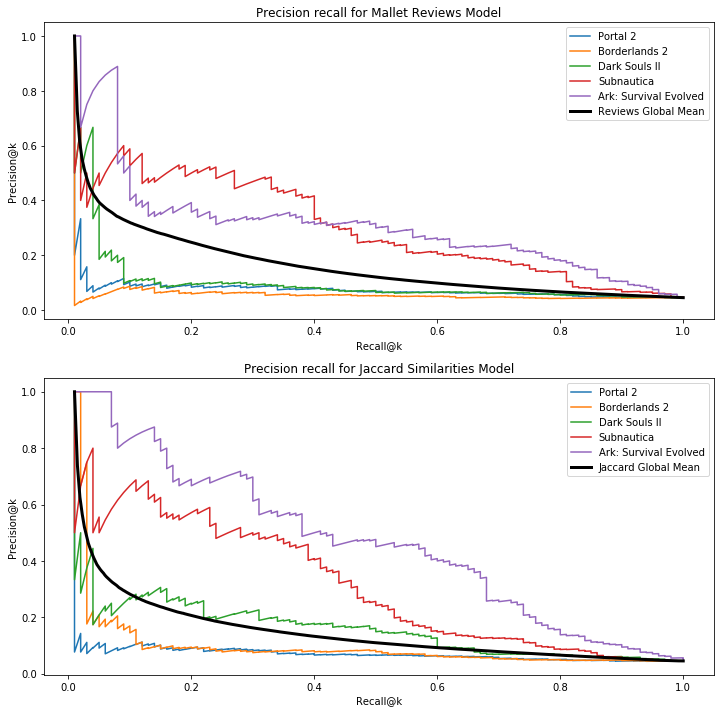

In [91]:
# fig = plt.figure(figsize=(12,6))
f, (ax1, ax2) = plt.subplots(2, figsize=(12,12))

ax1.set_title("Precision recall for Mallet Reviews Model")
ax1.set_xlabel("Recall@k")
ax1.set_ylabel("Precision@k")

for i, (app_index, name) in enumerate(sorted(queries.items())):
    precision, recall = precision_recall(app_index, reviews_sim, descriptions_sim)
    ax1.plot(recall, precision, label=name)    

total_precision_recall = np.zeros((len(app_ids), 2, len(app_ids)))
for app_index in xrange(len(app_ids)):
    total_precision_recall[app_index] = precision_recall(app_index, reviews_sim, descriptions_sim)
ax1.plot(total_precision_recall[:, 1, :].mean(axis=0),
         total_precision_recall[:, 0, :].mean(axis=0),
         linewidth=3,
         label="Reviews Global Mean",
         color="k")
ax1.legend()

ax2.set_title("Precision recall for Jaccard Similarities Model")
ax2.set_xlabel("Recall@k")
ax2.set_ylabel("Precision@k")

for i, (app_index, name) in enumerate(sorted(queries.items())):
    precision, recall = precision_recall(app_index, jaccard_sim, descriptions_sim)
    ax2.plot(recall, precision, label=name)    

total_precision_recall = np.zeros((len(app_ids), 2, len(app_ids)))
for app_index in xrange(len(app_ids)):
    total_precision_recall[app_index] = precision_recall(app_index, jaccard_sim, descriptions_sim)
plt.plot(total_precision_recall[:, 1, :].mean(axis=0),
         total_precision_recall[:, 0, :].mean(axis=0),
         linewidth=3,
         label="Jaccard Global Mean",
         color="k")
ax2.legend()

plt.show()